# Table of Contents
- [Problem Definition](#intro)
- [Modules/Libraries](#modules)
- [Exploratory Data Analysis](#eda)
- [Variable Transformation](#transformation)
- [Modeling & Prediction](#modeling)
- [Conclusion](#conclusion)

## 👨🏻‍💻 Problem Definition <a id="intro"></a>
Analyzing and predicting sleep time is crucial for understanding its impact on health, productivity, and well-being. It helps identify factors affecting sleep and provides actionable insights to improve sleep patterns and overall quality of life.

In this exercise, we will take a look at the [Sleep Time Prediction Dataset from Kaggle](https://www.kaggle.com/datasets/govindaramsriram/sleep-time-prediction/data) and evaluate how some human daily activity indicators (caffeine intake, work hours, phone usage, etc.) may impact sleep time.

## ⚒️ Import data & modules <a id="modules"></a>
We will mainly use some standard tools for data analysis, plus some visualization libraries to explore variables and relationships between them.

In [17]:
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, spearmanr, shapiro, boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer

In [20]:
# Use Kaggle API to import the dataset
path = kagglehub.dataset_download("govindaramsriram/sleep-time-prediction")
df = pd.read_csv(path + '/sleeptime_prediction_dataset.csv')

## 🔮 Exploratory Data Analysis (EDA) <a id="eda"></a>
Let's take a first look at the data and try to infer some relationship between variables and decide if we need some additional cleanup.

In [3]:
df.describe()

,WorkoutTime,ReadingTime,PhoneTime,WorkHours,CaffeineIntake,RelaxationTime,SleepTime
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1.495915,0.992785,2.985195,6.926945,147.493780,1.010955,4.884375
std,0.876639,0.577303,1.151776,1.723843,84.651139,0.582619,2.028892
min,0.010000,0.000000,1.000000,4.000000,0.020000,0.000000,0.150000
25%,0.710000,0.500000,1.990000,5.440000,75.980000,0.510000,3.840000
50%,1.520000,0.990000,2.965000,6.910000,146.010000,1.010000,4.600000
75%,2.250000,1.500000,3.960000,8.422500,218.902500,1.530000,5.470000
max,3.000000,2.000000,5.000000,10.000000,299.850000,2.000000,19.810000


> 💡 We are dealing with a dataset of 2k observations, 6 independent variables (`WorkoutTime`, `ReadingTime`, `PhoneTime`, `WorkHours`, `CaffeineIntake`, `RelaxationTime`) and one dependent variable `SleepTime`.

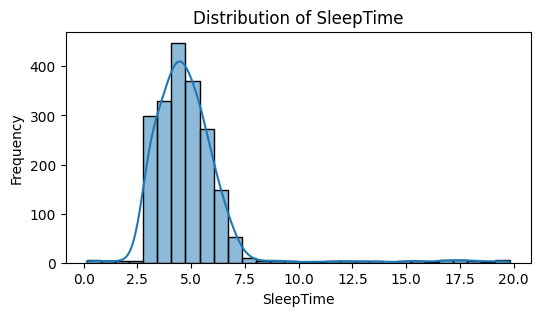

Shapiro-Wilk Test: Statistic=0.6535, p-value=0.0000
SleepTime does not appear to be normally distributed (reject H0).


In [4]:
# Let's check the distribution of the dependent variable
plt.figure(figsize=(6, 3))
sns.histplot(df['SleepTime'], kde=True, bins=30)
plt.title("Distribution of SleepTime")
plt.xlabel("SleepTime")
plt.ylabel("Frequency")
plt.show()

# Shapiro-Wilk test for normality
stat, p_value = shapiro(df['SleepTime'])
print(f"Shapiro-Wilk Test: Statistic={stat:.4f}, p-value={p_value:.4f}")

if p_value > 0.05:
    print("SleepTime appears to be normally distributed (fail to reject H0).")
else:
    print("SleepTime does not appear to be normally distributed (reject H0).")

> 💡 The `SleepTime` variable is not normally distributed. We may need to perform some additional variable transformations to increase prediction accuracy.

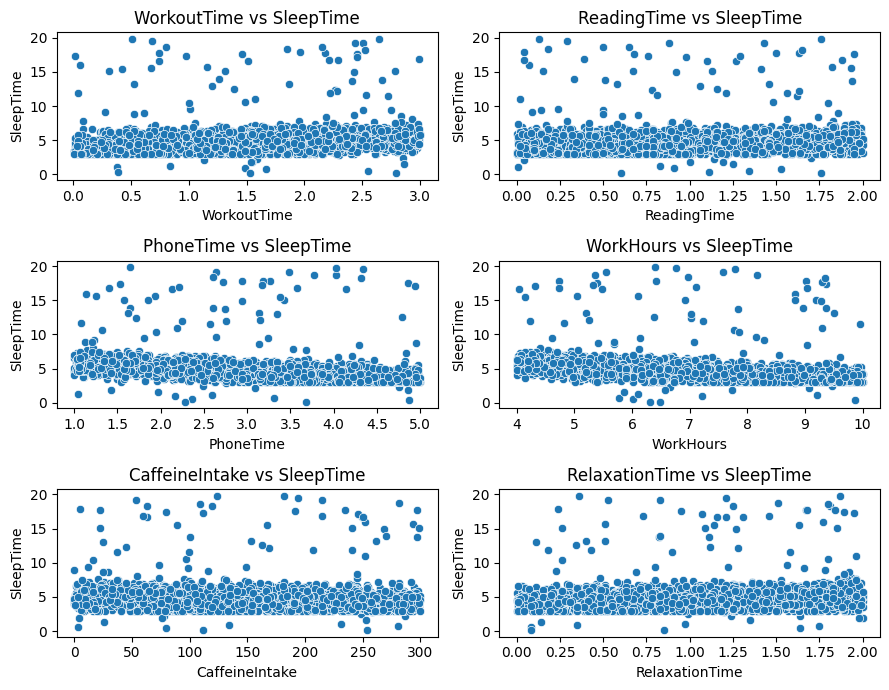

In [85]:
# Let's explore the nature of relationships between the predictors and dependend variable
# Scatterplots of variables vs SleepTime in smaller subplots
variables = ["WorkoutTime", "ReadingTime", "PhoneTime", "WorkHours", "CaffeineIntake", "RelaxationTime"]
num_vars = len(variables)
cols = 2
rows = (num_vars // cols) + (num_vars % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(9,7))
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.scatterplot(data=df, x=var, y="SleepTime", ax=axes[i])
    axes[i].set_title(f"{var} vs SleepTime")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("SleepTime")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [53]:
# Let's take a look at the independent variables and variability among them

# Calculate Standard Deviations
std_devs = df.std()
print("\nStandard Deviations of Variables:")
print(std_devs)

# Coefficient of Variation (CV) for each variable
mean_values = df.mean()
cv = (std_devs / mean_values) * 100
print("\nCoefficient of Variation (CV) for Variables:")
print(cv)


Standard Deviations of Variables:
WorkoutTime        0.876639
ReadingTime        0.577303
PhoneTime          1.151776
WorkHours          1.723843
CaffeineIntake    84.651139
RelaxationTime     0.582619
SleepTime          2.028892
dtype: float64

Coefficient of Variation (CV) for Variables:
WorkoutTime       58.602227
ReadingTime       58.149814
PhoneTime         38.582945
WorkHours         24.886049
CaffeineIntake    57.393023
RelaxationTime    57.630605
SleepTime         41.538417
dtype: float64


In [54]:
# Identify high variability variables
high_std_threshold = 50  # Arbitrary threshold
high_std_vars = cv[cv > high_std_threshold]

if not high_std_vars.empty:
    print("\nVariables with High Coefficient of Variation (>50%):")
    print(high_std_vars)

    # Remove outliers from high variability variables
    for var in high_std_vars.index:
        if var in df.columns:
            z_scores = np.abs((df[var] - df[var].mean()) / df[var].std())
            df = df[z_scores < 3]

    print("\nOutliers have been removed from the high variability variables.")

    # Standardize high variability variables
    scaler = StandardScaler()
    for var in high_std_vars.index:
        if var in df.columns:
            df[var] = scaler.fit_transform(df[[var]])

    print("\nHigh variability variables have been standardized and replaced in the dataset.")


Variables with High Coefficient of Variation (>50%):
WorkoutTime       58.602227
ReadingTime       58.149814
CaffeineIntake    57.393023
RelaxationTime    57.630605
dtype: float64

Outliers have been removed from the square root transformed variables.


> Interestingly, the relationship betwen `SleepTime` and all dependent variables is non-linear, almost flat. We might want to look in the direction of non-linear models afterwards (Random Forests, Gradient Boosting, etc.)

> Another idea is to perform some qualitative/quantitative variable transformation:
> * categorization
> * feature engineering (combination, ratios, interactions)
> * encoding
> * feature reduction

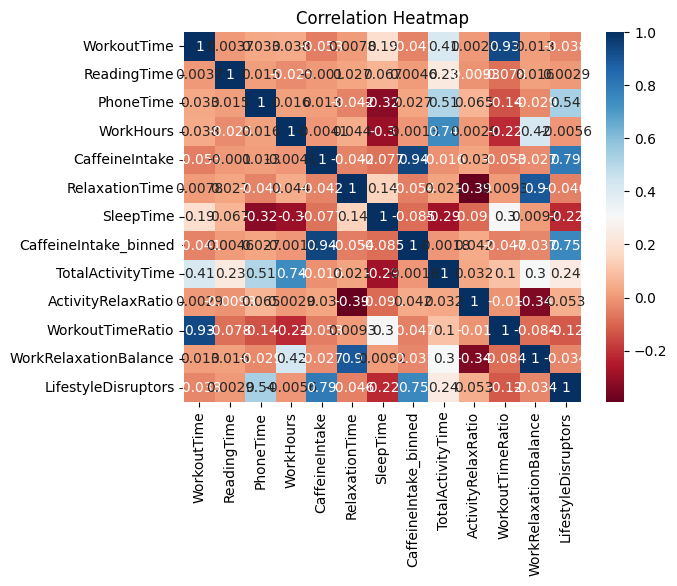

In [39]:
# Let's initially check the correlation matrix
sns.heatmap(df.corr(), cmap='RdBu',annot=True)
plt.title('Correlation Heatmap')
plt.show()

> Not so much to work with, let's perform some variable transformations!

## ✨ Variable Transformation <a id="transformation"></a>
As we have seen earlier, the relationships between dependent and independent variables is quite flat. To improve that, let's apply some common variable transformation techniques.

In [34]:
# First, let's create a new variable
# Each individual variable may not be very informative 
# Let's sum them all up to calculate Total Activity Time 

df['TotalActivityTime'] = df['WorkoutTime'] + df['ReadingTime'] + df['PhoneTime'] + df['WorkHours']

In [35]:
# There's one variable that strikes a sharp contrast with others
# Relaxation Time should logically be the opposite of Activity
# Let's introduce another variable: Activity vs Relaxation Ratio

df['ActivityRelaxRatio'] = df['TotalActivityTime'] / df['RelaxationTime']

In [36]:
# Physical activity is known to have a huge impact on sleep
# Let's calculate how high the % of physical activity is relative to total activity time

df['WorkoutTimeRatio'] = df['WorkoutTime'] / df['TotalActivityTime']

In [37]:
# Another good technique is to create new variable combinations
# Sometimes combinations are more meaningful predictors than individual variables

# This combination reflext the balance (imbalance) between work and relaxation
df['WorkRelaxationBalance'] = df['WorkHours'] * df['RelaxationTime']

# This combination represents some behavioral habits that may negatively impact sleep
df['LifestyleDisruptors'] = df['PhoneTime'] * df['CaffeineIntake']

In [38]:
# Auto-bucketing of CaffeineIntake using KBinsDiscretizer
kbd = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df['CaffeineIntake_binned'] = kbd.fit_transform(df[['CaffeineIntake']]).astype(int)
print("\nCaffeineIntake has been auto-bucketed into categories:")
print(df['CaffeineIntake_binned'].value_counts())

# Map bin labels for better interpretation
bin_edges = kbd.bin_edges_[0]
labels = [f"{bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]
df['CaffeineIntake_binned_label'] = df['CaffeineIntake_binned'].map(dict(enumerate(labels)))
print("\nCaffeineIntake Binned Labels:")
print(df[['CaffeineIntake_binned', 'CaffeineIntake_binned_label']].drop_duplicates())

# No need for labels in the final dataset
df.drop('CaffeineIntake_binned_label', axis=1, inplace=True)



CaffeineIntake has been auto-bucketed into categories:
CaffeineIntake_binned
2    667
0    667
1    666
Name: count, dtype: int64

CaffeineIntake Binned Labels:
   CaffeineIntake_binned CaffeineIntake_binned_label
0                      2             194.68 - 299.85
2                      0                0.02 - 99.70
4                      1              99.70 - 194.68


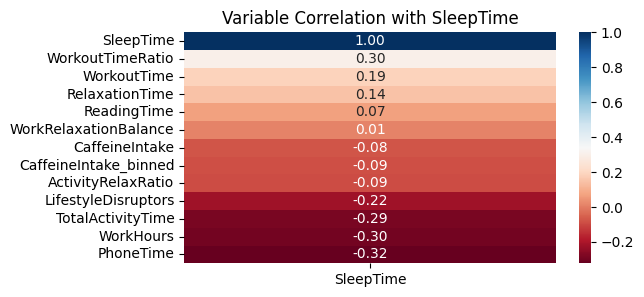

In [46]:
# Let's look at the final set of variables
correlation_matrix = df.corr(numeric_only=True)['SleepTime'].sort_values(ascending=False)
plt.figure(figsize=(6, 3))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='RdBu', fmt='.2f')
plt.title('Variable Correlation with SleepTime')
plt.show()

> 💡 Looks like not all the transformations were fruitful. For the prediction exercise, let's consider only the variables with a relatively high correlation (let's take **0.25** as a threshold). 

In [84]:
# Define the threshold
threshold = 0.25

# Select high-correlation features
correlation_matrix = correlation_matrix.abs()
high_corr_variables = correlation_matrix[correlation_matrix['SleepTime'] >= threshold].index.to_list()
high_corr_variables.remove('SleepTime')

print('High Correlation Variables to be used in the model: \n', high_corr_variables)

High Correlation Variables to be used in the model: 
 ['WorkoutTimeRatio', 'TotalActivityTime', 'WorkHours', 'PhoneTime']


## 🚀 Modeling & Prediction <a id="modeling"></a>
Let's do the standard modeling exercise. We will use several models and pick the best suitable one with the highest accuracy.